In [1]:
import gmaps
import pandas as pd
import requests as re
import json
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
from ipython_config import gkey
print(gkey)

test


In [4]:
data = pd.read_csv('Hospital_General_Information.csv')
hospital_df = pd.DataFrame(data)
hospital_df.columns
hospital_df.columns
NC = hospital_df.loc[hospital_df['State']=='NC']
county = NC.groupby(['County Name'])

In [5]:
hospital_df['Hospital overall rating'].value_counts()

Not Available    1761
4                1133
3                1109
2                 702
5                 407
1                 227
Name: Hospital overall rating, dtype: int64

In [115]:
del NC['Hospital overall rating footnote']
del NC['Mortality national comparison footnote']
del NC['Safety of care national comparison footnote']
del NC['Readmission national comparison footnote']
del NC['Patient experience national comparison footnote']
del NC['Efficient use of medical imaging national comparison footnote']
del NC['Effectiveness of care national comparison footnote']
del NC['Timeliness of care national comparison footnote']
del NC['Facility ID']
del NC['Address']
del NC['City']
del NC['State']
del NC['ZIP Code']
del NC['Phone Number']
NC.head(15)

,Facility Name,County Name,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,Location
14,MARIA PARHAM MEDICAL CENTER,VANCE,Acute Care Hospitals,Proprietary,True,True,2,Same as the national average,Same as the national average,Below the national average,Below the national average,Same as the national average,Below the national average,Same as the national average,NaN
15,CHEROKEE INDIAN HOSPITAL AUTHORITY,SWAIN,Acute Care Hospitals,Government - Federal,True,NaN,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,NaN
16,ALLEGHANY COUNTY MEMORIAL HOSPITAL,ALLEGHANY,Critical Access Hospitals,Voluntary non-profit - Private,True,NaN,2,Not Available,Not Available,Below the national average,Not Available,Not Available,Above the national average,Same as the national average,NaN
72,WAYNE MEMORIAL HOSPITAL,WAYNE,Acute Care Hospitals,Voluntary non-profit - Private,True,True,2,Below the national average,Same as the national average,Below the national average,Below the national average,Same as the national average,Below the national average,Same as the national average,POINT (-77.953342 35.400831)
95,LAKE NORMAN REGIONAL MEDICAL CENTER,IREDELL,Acute Care Hospitals,Proprietary,True,True,2,Same as the national average,Same as the national average,Below the national average,Below the national average,Same as the national average,Above the national average,Same as the national average,POINT (-80.852939 35.547748)
109,CAPE FEAR VALLEY-BLADEN COUNTY HOSPITAL,BLADEN,Critical Access Hospitals,Voluntary non-profit - Private,True,NaN,3,Same as the national average,Not Available,Same as the national average,Not Available,Not Available,Below the national average,Same as the national average,POINT (-78.608298 34.623474)
128,WILSON MEDICAL CENTER,WILSON,Acute Care Hospitals,Voluntary non-profit - Private,True,True,2,Below the national average,Above the national average,Below the national average,Below the national average,Same as the national average,Below the national average,Same as the national average,POINT (-77.944047 35.720524)
150,OLD VINEYARD YOUTH SERVICES,FORSYTH,Psychiatric,Proprietary,False,NaN,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,POINT (-80.318902 36.077679)
261,ATRIUM HEALTH UNIVERSITY CITY,MECKLENBURG,Acute Care Hospitals,Government - Hospital District or Authority,True,True,4,Same as the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Below the national average,Above the national average,POINT (-80.747985 35.307836)
266,CAROLINAS HEALTHCARE SYSTEM-BLUE RIDGE,BURKE,Acute Care Hospitals,Proprietary,True,True,4,Same as the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Same as the national average,Same as the national average,POINT (-81.658223 35.723793)


In [122]:
#  NC['Hospital overall rating'] = NC['Hospital overall rating'].replace({'Not Available':'2'})
NC['Hospital overall rating'] = NC['Hospital overall rating'].astype('float')
averages=NC.groupby('County Name').mean()
averages

C:\Users\littl\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


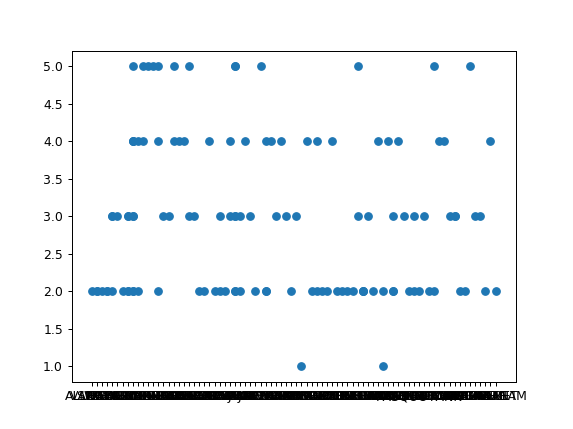

In [129]:
plt.scatter(NC['County Name'],NC['Hospital overall rating'])

In [ ]:
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
params = {
    "location": "39.952583,-75.16522",  # philadelphia coords,
    "rankby": "distance",
    "type": "hospital",
    "key": gkey,
}
